<a href="https://colab.research.google.com/github/carmenpelayo/Carmen-Pelayo/blob/main/Recommendation_System_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Module Imports

import pandas as pd
from pandas import *
from numpy import array
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# H2020 Projects DB
This database includes information about the initiatives presented in the *Horizon 2020* program, managed by the European Comission. For the purposes of this program, only those belonging to the the information and communication technologies' field (ICTs) were selected. The entries of this dataset correspond to the participations received in the Horizon 2020 program, being a single entity able to participate in several projects, and a project able to be developed by multiple entities. *Horizon 2020* received participations from 2014 to 2020, therefore the entries in this dataset measures initiatives presented throughout the entire program cycle (6 years).

In [ ]:
xlsx = pd.ExcelFile('/content/drive/MyDrive/TFG/Datasets/ICT_H2020.xlsx')
projects = pd.read_excel(xlsx, 'Proyectos')
areas = pd.read_excel(xlsx, 'Areas')

## Data quality validation 
Proof that Investment in ICT and GDP are correlated:

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


0.9302407340875096


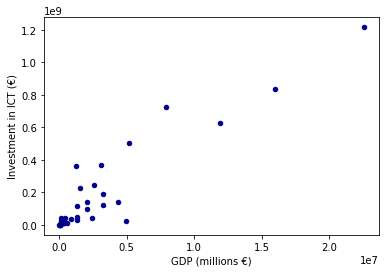

In [ ]:
# DESI index
df_gpd = pd.read_excel('/content/drive/MyDrive/TFG/Datasets/GPD_countries.xlsx', sheet_name = 'Resumen')
df_gpd = df_gpd.loc[:, ['country','gpd']] # Select relevant columns

# ICT Projects
df_p = projects.loc[:, ['Country Code', 'EU Contribution (€)']] # Select relevant columns
df_p.replace('-',0.0, inplace = True) # Fix non-zero values
df_countries = df_p.groupby('Country Code').sum().reset_index() # Group by country
df_countries.columns = ['country', 'grants'] # Change column names

# Merge dataframes
df = pd.merge(df_gpd, df_countries, how = 'inner', on = 'country') # Merge values
ax1 = df.plot.scatter(x='gpd',y='grants', c='DarkBlue') # Scatter Plot
ax1.set_xlabel("GDP (millions €)")
ax1.set_ylabel("Investment in ICT (€)")

# Correlation Coefficient
correl = df.loc[:, 'gpd'].corr(df.loc[:, 'grants']) # Correlation computation
print(correl) 

## Data Cleaning
### Cleaning db "areas"

In [ ]:
#PROBLEM 1: two different area names for communication: "Comunicación" and "communication"
#PROBLEM 2: some area names are in English and others in Spanish
#PROBLEM 3: some column names are in English
#PROBLEM 4: change "Topic" to "Topic Code" (col 2 name) to match the same name as in "projects" df

areas_col = areas["Area"]
err_corr = {"Comunicación": "Media & Communication", "communication": "Media & Communication", "Media": "Media & Communication", "Computación": "Computing", "ciberseguridad": "Cybersecurity", "Robot": "Robotics", "Otros": "Other", "Innovación": "Innovation", "Big data": "Big Data"}
for k in err_corr:
  areas_col = areas_col.replace(k, err_corr[k])
areas.Area = areas_col

#Clean df
areas = areas.rename(columns={"Topic": "Topic Code", "Descripción": "Description"})   

### Cleaning df "projects"

In [ ]:
list(projects.columns)

['Framework Programme',
 'Call ID',
 'Topic Code',
 'Topic Descr',
 'Project Nbr',
 'CORDIS link',
 'Project Acronym',
 'Project Title',
 'Partner Role',
 'Partner Type',
 'General PIC',
 'Legal Entity VAT',
 'Legal Name',
 'Legal Entity Type',
 'Legal Entity Type Descr',
 'City',
 'NUTS 3 Code',
 'NUTS 3 Name',
 'Country Code',
 'Country',
 'EU Contribution (€)',
 'H2020 Net EU Contribution',
 'H2020 Total Cost',
 'Signature Date',
 'Call Deadline  Date',
 'Thematic Priority Abbr',
 'Thematic Priority Descr',
 'SME Flag',
 'Project Start Date',
 'Project End Date',
 'Pillar Abbr',
 'Pillar Descr',
 'Simplified Type of Action',
 'Focus Area']

Meaningless columns -> observed with groupby method that all rows have the same value for those columns (they do not provide any useful information for the study).

- Pillar Descr
- General PIC
- Thematic Priority Abbr
- Thematic Priority Descr
- Pillar Abbr
- Pillar Descr
- Focus Area -> most rows do not have a value for this column

Therefore, we can eliminate them from the database.

In [ ]:
meaningless_cols = ['Pillar Descr', 'General PIC', 'Thematic Priority Abbr', 'Thematic Priority Descr', 'Pillar Abbr', 'Pillar Descr', 'Simplified Type of Action', 'Focus Area']
projects.drop(meaningless_cols, axis = 1, inplace = True)

Now we need to obtain the NUTS 2 codes (which will represent the different location options for businesses). It can be done by simply taking the first 2 digits of the NUTS 3 code.

In [ ]:
#Getting NUTS2 codes
projects['NUTS 2 Code'] = projects['NUTS 3 Code'].str[:4]

#Deleting the project with unspecified region from "projects" df
idx = projects[projects["NUTS 2 Code"] == "-"].index.tolist()[0]
projects = projects.drop(idx)

### Merge of "projects" and "areas"
We will merge both dataframes ("projects" and "areas") by topic ("AI", "Cibersecurity", "Robotics", etc.), and define the merged dataframes with the name "projects". We maintain that name because the resulting dataframe still describes the H2020 projects, with the merge we are only adding information on the market area (or topic) of specialization.

In [ ]:
projects = pd.merge(projects, areas, on = 'Topic Code') 

This will give us the clean and definitive "projects" dataframe.

In [ ]:
projects

,Framework Programme,Call ID,Topic Code,Topic Descr,Project Nbr,CORDIS link,Project Acronym,Project Title,Partner Role,Partner Type,...,H2020 Net EU Contribution,H2020 Total Cost,Signature Date,Call Deadline Date,SME Flag,Project Start Date,Project End Date,NUTS 2 Code,Area,Description
0,H2020,ECSEL-2014-1,ECSEL-01-2014,ECSEL Key Applications and Essential Technolog...,661933,http://cordis.europa.eu/project/id/661933,RobustSENSE,Robust and Reliable Environment Sensing and Si...,COORDINATOR,BENEFICIARY,...,335222.0,897410.0,16/06/2015,17/09/2014,No,01/06/2015,31/05/2018,DE11,Other,ECSEL Key Applications and Essential Technolog...
1,H2020,ECSEL-2014-1,ECSEL-01-2014,ECSEL Key Applications and Essential Technolog...,661933,http://cordis.europa.eu/project/id/661933,RobustSENSE,Robust and Reliable Environment Sensing and Si...,PARTICIPANT,BENEFICIARY,...,126750.0,390000.0,16/06/2015,17/09/2014,No,01/06/2015,31/05/2018,FI1B,Other,ECSEL Key Applications and Essential Technolog...
2,H2020,ECSEL-2014-1,ECSEL-01-2014,ECSEL Key Applications and Essential Technolog...,661933,http://cordis.europa.eu/project/id/661933,RobustSENSE,Robust and Reliable Environment Sensing and Si...,PARTICIPANT,BENEFICIARY,...,82523.0,336100.0,16/06/2015,17/09/2014,No,01/06/2015,31/05/2018,DE71,Other,ECSEL Key Applications and Essential Technolog...
3,H2020,ECSEL-2014-1,ECSEL-01-2014,ECSEL Key Applications and Essential Technolog...,661933,http://cordis.europa.eu/project/id/661933,RobustSENSE,Robust and Reliable Environment Sensing and Si...,PARTICIPANT,BENEFICIARY,...,61165.0,188000.0,16/06/2015,17/09/2014,Yes,01/06/2015,31/05/2018,FI1D,Other,ECSEL Key Applications and Essential Technolog...
4,H2020,ECSEL-2014-1,ECSEL-01-2014,ECSEL Key Applications and Essential Technolog...,661933,http://cordis.europa.eu/project/id/661933,RobustSENSE,Robust and Reliable Environment Sensing and Si...,PARTICIPANT,BENEFICIARY,...,201013.0,618500.0,16/06/2015,17/09/2014,No,01/06/2015,31/05/2018,ES51,Other,ECSEL Key Applications and Essential Technolog...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18406,H2020,H2020-SU-ICT-2019,SU-ICT-02-2020,Building blocks for resilience in evolving ICT...,952702,http://cordis.europa.eu/project/id/952702,BIECO,Building Trust in Ecosystems and Ecosystem Com...,PARTICIPANT,BENEFICIARY,...,439687.5,439687.5,21/08/2020,19/11/2019,No,01/09/2020,31/08/2023,ES62,Cybersecurity,Building blocks for resilience in evolving ICT...
18407,H2020,H2020-SU-ICT-2019,SU-ICT-02-2020,Building blocks for resilience in evolving ICT...,952702,http://cordis.europa.eu/project/id/952702,BIECO,Building Trust in Ecosystems and Ecosystem Com...,PARTICIPANT,BENEFICIARY,...,431250.0,431250.0,21/08/2020,19/11/2019,No,01/09/2020,31/08/2023,RO11,Cybersecurity,Building blocks for resilience in evolving ICT...
18408,H2020,H2020-SU-ICT-2019,SU-ICT-02-2020,Building blocks for resilience in evolving ICT...,952702,http://cordis.europa.eu/project/id/952702,BIECO,Building Trust in Ecosystems and Ecosystem Com...,PARTICIPANT,BENEFICIARY,...,435000.0,435000.0,21/08/2020,19/11/2019,No,01/09/2020,31/08/2023,ITI4,Cybersecurity,Building blocks for resilience in evolving ICT...
18409,H2020,H2020-SU-ICT-2019,SU-ICT-02-2020,Building blocks for resilience in evolving ICT...,952702,http://cordis.europa.eu/project/id/952702,BIECO,Building Trust in Ecosystems and Ecosystem Com...,PARTICIPANT,BENEFICIARY,...,588412.5,588412.5,21/08/2020,19/11/2019,No,01/09/2020,31/08/2023,DE21,Cybersecurity,Building blocks for resilience in evolving ICT...


## Data Analysis


### DIMENSION 1: Tech Areas
Some tech area (or topic) names ("Other", "SME" and "Innovation") do not communicate clear information on the type of products/services they deal with. For this reason, we will not take them into account in the computation of the market areas of specialization of each European region.

In [ ]:
no_topics = ["Other", "SME", "Innovation"]
sel_topics = projects[-projects["Area"].isin(no_topics)] #Selection of projects with a specific market area (or topic) of specialization

We are interested in obtaining the total cost of all projects in a specific market area for each location, so as obtain the popularity or expertise of that area in the region.

In [ ]:
topics = sel_topics.groupby(["NUTS 2 Code", "Area"]).sum()["H2020 Total Cost"].reset_index()  
topics = topics.pivot(index = "NUTS 2 Code", columns = "Area", values = "H2020 Total Cost").reset_index()
topics

Area,NUTS 2 Code,AI,Big Data,Computation,Cybersecurity,Internet,IoT,Media & Communication,Robotics,Software
0,AT11,NaN,1125750.00,NaN,NaN,NaN,NaN,76250.00,NaN,NaN
1,AT12,NaN,NaN,NaN,192500.00,NaN,848073.75,116250.00,1657268.75,NaN
2,AT13,2334602.50,10364412.02,5637025.00,8013476.51,1166912.38,7433443.50,10242138.00,5783371.25,3107365.00
3,AT21,NaN,1471282.50,1521836.25,1698992.53,885125.00,3076921.60,739250.00,1124710.00,379000.00
4,AT22,1828511.50,6151000.14,867727.50,2741263.20,555375.00,4227233.75,5641575.00,716430.00,1598062.50
...,...,...,...,...,...,...,...,...,...,...
253,UKM5,NaN,NaN,NaN,NaN,1055257.50,587296.50,NaN,NaN,NaN
254,UKM7,5561515.00,2552092.50,3149152.50,929375.00,691627.50,912836.75,2408333.45,7439751.90,1074775.12
255,UKM8,1173435.25,1800120.00,32500.00,NaN,1457848.75,547232.25,3938520.30,1415715.00,NaN
256,UKM9,NaN,NaN,NaN,NaN,256250.00,NaN,NaN,NaN,NaN


### DIMENSION 2: Company Size (SME LE)
It is important to determine whether an institution is a SME (Small/Medium Enterprise) because that generally indicates that the organization is in the initial phase, when it needs capital to start up operations and grow. On the opposite, a LE (Large Enterprise, those that are not a SME) is an indicative of a mature, established company in the market, which will rather require capital to maintain operations and innovate. 

In [ ]:
smes = projects.groupby(["NUTS 2 Code", "SME Flag"]).count().Country.reset_index()
smes = smes.pivot(index = "NUTS 2 Code", columns = "SME Flag", values = "Country").reset_index()
smes

SME Flag,NUTS 2 Code,No,Yes
0,AL02,3.0,NaN
1,AT11,13.0,3.0
2,AT12,9.0,11.0
3,AT13,202.0,56.0
4,AT21,55.0,26.0
...,...,...,...
283,UKM6,1.0,NaN
284,UKM7,50.0,26.0
285,UKM8,30.0,9.0
286,UKM9,1.0,2.0


### DIMENSION 3: Technological Maturity
Number of projects dedicated to researching, developing or integrating technology in services  within each region. Considering data on "Entity Type", it will be assumed that:
- "HES" = Higher or secondary education -> Research
- "REC" = Research organisations -> Development
- "PRC" = Private for profit (excl. education) -> Integration
- Public body (excl. research and education) -> will not taken into consideration in the computation.
- Others -> not specified, will not taken into consideration in the computation.

In [ ]:
mat_types = ["PRC", "REC", "HES"]
sel_mat = projects[projects["Legal Entity Type"].isin(mat_types)] #Selection of projects with a maturity type
maturities = sel_mat.groupby(["NUTS 2 Code", "Legal Entity Type"]).count().Country.reset_index()
maturities = maturities.pivot(index = "NUTS 2 Code", columns = "Legal Entity Type", values = "Country").reset_index()
maturities

Legal Entity Type,NUTS 2 Code,HES,PRC,REC
0,AL02,2.0,NaN,1.0
1,AT11,5.0,5.0,5.0
2,AT12,2.0,16.0,NaN
3,AT13,57.0,131.0,53.0
4,AT21,10.0,69.0,2.0
...,...,...,...,...
281,UKM6,NaN,1.0,NaN
282,UKM7,44.0,19.0,9.0
283,UKM8,26.0,11.0,1.0
284,UKM9,NaN,3.0,NaN


### DIMENSION 4: EU Grants
This dimension will measure the euro amount of capital grants received by each European region in H2020 projects.

In [ ]:
grants = projects.groupby("NUTS 2 Code").sum()[["H2020 Net EU Contribution"]].reset_index()
grants

,NUTS 2 Code,H2020 Net EU Contribution
0,AL02,268275.00
1,AT11,3617395.47
2,AT12,5086023.63
3,AT13,84302485.44
4,AT21,36136956.83
...,...,...
283,UKM6,104731.12
284,UKM7,36131328.33
285,UKM8,17480737.58
286,UKM9,740257.81


# Countries' Digitalization DB
This dataset contains information on the readiness of European countries to deploy and adopt 5G technologies. It gives the different European countries a score (0 to 100) for each of the factors that determine the level of digitalization of a nation. This dataset was obtained from a report published by Incites Consulting S.A. in 2020.

In [ ]:
digitalization = pd.read_csv("/content/drive/MyDrive/TFG/Datasets/Subfactor score table.csv")
digitalization

,Country,4G coverage,Fiber coverage,Internet BW per user,5G commercial networks,# of IXPs,# & maturity of 5G pilots,Time to get electricity,4G launch year,5G spectrum auction plans,...,VC availability,Tertiary (%),Skillset of univrsity graduates,Extent of staff training,Availability of scientists & engineers,e-Gov services,Competition in network services,GDP per capita,ICTs & business model creation,Internet users (% of population)
0,Finland,89.50,37.5,62.05,100.0,10.11,30.15,86.55,90.91,66.67,...,68.81,62.76,78.09,75.25,83.84,96.5,76.29,86.24,85.00,88.89
1,Switzerland,89.60,30.3,61.50,100.0,30.32,23.60,87.54,72.73,66.67,...,56.00,42.38,83.56,78.97,68.76,84.7,68.46,88.82,85.00,89.81
2,Germany,76.90,8.5,55.92,100.0,80.85,64.24,91.15,90.91,66.67,...,63.42,49.99,70.84,65.26,69.24,93.1,73.07,87.12,78.33,89.74
3,Denmark,88.60,64.4,62.59,25.0,12.63,10.49,87.87,90.91,33.33,...,46.50,57.37,75.01,71.17,56.60,100.0,62.60,87.17,75.00,97.64
4,Sweden,91.10,72.2,58.91,25.0,45.48,7.87,83.27,100.00,50.00,...,56.36,47.67,74.92,70.73,64.03,94.4,72.07,87.28,81.67,92.14
5,United Kingdom,84.70,3.8,84.68,100.0,68.22,56.37,85.24,72.73,50.00,...,57.93,42.70,67.54,62.67,64.81,97.9,68.36,86.05,80.00,94.90
6,Netherlands,92.80,35.1,67.04,50.0,27.79,30.15,66.88,77.27,33.33,...,56.39,60.47,76.90,72.44,64.26,93.1,77.12,87.81,83.33,94.71
7,Norway,95.90,58.7,63.85,50.0,17.69,22.29,78.68,100.00,66.67,...,48.45,58.34,70.87,68.23,67.52,95.1,67.45,89.99,73.33,96.49
8,Luxembourg,86.60,63.4,98.72,50.0,5.05,3.93,81.96,72.73,33.33,...,57.74,13.63,74.56,75.15,50.11,92.4,64.91,92.80,80.00,97.06
9,Austria,86.60,13.0,55.55,100.0,12.63,10.49,92.78,90.91,50.00,...,45.17,60.53,74.97,68.43,58.76,86.8,72.95,87.12,73.33,87.71


As the indicators are measured at a national (rather that at a regional level), we will set the same value for all the regions in a country. To do so, we will merge the countries of each region in the "projects" dataframe with the countries in the "digitalization" dataframe. This way we will acquire the country name corresponding to each NUTS 2 Code (region).

In [ ]:
reg_nat = projects[["NUTS 2 Code","Country"]]
digitalization = digitalization.merge(reg_nat, on= "Country")
digitalization

,Country,4G coverage,Fiber coverage,Internet BW per user,5G commercial networks,# of IXPs,# & maturity of 5G pilots,Time to get electricity,4G launch year,5G spectrum auction plans,...,Tertiary (%),Skillset of univrsity graduates,Extent of staff training,Availability of scientists & engineers,e-Gov services,Competition in network services,GDP per capita,ICTs & business model creation,Internet users (% of population),NUTS 2 Code
0,Finland,89.50,37.5,62.05,100.0,10.11,30.15,86.55,90.91,66.67,...,62.76,78.09,75.25,83.84,96.5,76.29,86.24,85.00,88.89,FI1B
1,Finland,89.50,37.5,62.05,100.0,10.11,30.15,86.55,90.91,66.67,...,62.76,78.09,75.25,83.84,96.5,76.29,86.24,85.00,88.89,FI1D
2,Finland,89.50,37.5,62.05,100.0,10.11,30.15,86.55,90.91,66.67,...,62.76,78.09,75.25,83.84,96.5,76.29,86.24,85.00,88.89,FI19
3,Finland,89.50,37.5,62.05,100.0,10.11,30.15,86.55,90.91,66.67,...,62.76,78.09,75.25,83.84,96.5,76.29,86.24,85.00,88.89,FI19
4,Finland,89.50,37.5,62.05,100.0,10.11,30.15,86.55,90.91,66.67,...,62.76,78.09,75.25,83.84,96.5,76.29,86.24,85.00,88.89,FI1B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18048,North Macedonia,82.62,0.5,59.36,25.0,2.53,0.00,68.52,63.64,0.00,...,29.18,42.95,36.71,5.35,71.5,50.56,77.69,48.33,79.17,MK00
18049,North Macedonia,82.62,0.5,59.36,25.0,2.53,0.00,68.52,63.64,0.00,...,29.18,42.95,36.71,5.35,71.5,50.56,77.69,48.33,79.17,MK00
18050,North Macedonia,82.62,0.5,59.36,25.0,2.53,0.00,68.52,63.64,0.00,...,29.18,42.95,36.71,5.35,71.5,50.56,77.69,48.33,79.17,MK00
18051,North Macedonia,82.62,0.5,59.36,25.0,2.53,0.00,68.52,63.64,0.00,...,29.18,42.95,36.71,5.35,71.5,50.56,77.69,48.33,79.17,MK00


### DIMENSION 4.2: Capital
As there are several variables indicating the capital availability in a region, we will assign the value of "capital" to be the average of all these individual variables ('FDI & technology transfer', 'R&D expenditure (% of GDP)', 'VC availability').

In [ ]:
capital_cols = digitalization[['NUTS 2 Code','FDI & technology transfer','R&D expenditure (% of GDP)','VC availability']]
capital_cols["Average Capital"] = capital_cols.mean(axis=1)
capital = capital_cols.groupby("NUTS 2 Code").mean()[["Average Capital"]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### DIMENSION 5: Human Resources
As there are several variables indicating the human resources availability in a region, we will assign the value of "hhrr" to be the average of all these individual variables: 'Researchers in R&D', 'University-industry collaboration', 'Skillset of univrsity graduates', 'Extent of staff training' and 'Availability of scientists & engineers'.

In [ ]:
hhrr_cols = digitalization[['NUTS 2 Code','Researchers in R&D','University-industry collaboration', 'Skillset of univrsity graduates', 'Extent of staff training', 'Availability of scientists & engineers']]
hhrr_cols["Average HHRR"] = hhrr_cols.mean(axis=1)
hhrr = hhrr_cols.groupby("NUTS 2 Code").mean()[["Average HHRR"]]
hhrr

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Average HHRR
NUTS 2 Code,
AL02,37.762
AT11,63.030
AT12,63.030
AT13,63.030
AT21,63.030
...,...
UKM6,61.014
UKM7,61.014
UKM8,61.014


### DIMENSION 7: Government
This dimension measures the legal easiness to operate an ICT business. As there are several variables indicating the effect of governmental policies in a region, we will assign the value of "legal" to be the average of all these individual variables: 'Govt ensuring policy stability', 'Legal fwk's adaptability to digital BMs', 'Efficiency in settling disputes', 'Efficiency in challenging regulations', 'Burden of govt regulation', '# of days to start a business' and 'e-Gov services'.

In [ ]:
legal_cols = digitalization[['NUTS 2 Code','Govt ensuring policy stability', "Legal fwk's adaptability to digital BMs", 'Efficiency in settling disputes', 'Efficiency in challenging regulations', 'Burden of govt regulation', '# of days to start a business', 'e-Gov services']]
legal_cols["Average Legal"] = legal_cols.mean(axis=1)
legal = legal_cols.groupby("NUTS 2 Code").mean()[["Average Legal"]]
legal

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Average Legal
NUTS 2 Code,
AL02,50.641429
AT11,63.340000
AT12,63.340000
AT13,63.340000
AT21,63.340000
...,...
UKM6,71.037143
UKM7,71.037143
UKM8,71.037143


### DIMENSION 8: Tech Infrastructure
This dimension measures the technical readiness of regions, observed in the quality and extensiveness of the physical infrastructure. As there are several variables indicating the effect of governmental policies in a region, we will assign the value of "infrastructure" to be the average of all these individual variables: '4G coverage', 'Fiber coverage', 'Internet BW per user', '5G commercial networks', '# of IXPs', '# & maturity of 5G pilots', 'Time to get electricity', '4G launch year' and '5G spectrum auction plans'.

In [ ]:
infrastructure_cols = digitalization[['NUTS 2 Code','4G coverage', 'Fiber coverage', 'Internet BW per user', '5G commercial networks', '# of IXPs', '# & maturity of 5G pilots', 'Time to get electricity', '4G launch year', '5G spectrum auction plans']]
infrastructure_cols["Average Infrastructure"] = infrastructure_cols.mean(axis=1)
infrastructure = infrastructure_cols.groupby("NUTS 2 Code").mean()[["Average Infrastructure"]]
infrastructure

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Average Infrastructure
NUTS 2 Code,
AL02,32.496667
AT11,56.884444
AT12,56.884444
AT13,56.884444
AT21,56.884444
...,...
UKM6,67.304444
UKM7,67.304444
UKM8,67.304444


# Tech Hubs DB
This quantifies the number of tech hubs each region in Europe has. Data on this dataset was collected by Eurostat in 2020.

In [ ]:
hubs = pd.read_excel('/content/drive/MyDrive/TFG/Datasets/digital-innovation-hubs.xlsx')
hubs

,DIH Name,Location,City,Country,Website,NUTS2 Code,NUTS2 Name
0,Aachen DIH Center for Robotics in Healthcare,Pauwelsstraße 30,Aachen,Germany,http://www.robotics.ukaachen.de/,DEA2,Köln
1,Aalen University / Transfer Platform Industry 4.0,"Beethovenstraße, 1",Aalen,Germany,http://www.hs-aalen.de/,DE11,Stuttgart
2,"Aarhus University Centre for Digitalisation, B...",Finlandsgade 22,Aarhus,Denmark,http://www.digit.au.dk,DK04,Midtjylland
3,Accelerating Photonics innovation for SME’s (A...,"Brussels Photonics B-PHOT, Vrije Universiteit ...",Brussel,Belgium,http://www.actphast.eu,BE10,Région de Bruxelles-Capitale / Brussels Hoofds...
4,ADAPT Centre,"O'Reilly Building, Trinity College Dublin",Dublin,Ireland,https://www.adaptcentre.ie/,IE02,Southern and Eastern (NUTS 2013)
...,...,...,...,...,...,...,...
703,5G Fieldlab 5Groningen,Zernikelaan 17,GRONINGEN,Netherlands,https://www.5groningen.nl/,NL11,Groningen
704,5G Test Network Finland (5GTNF),Kaitoväylä 1,Oulu,Finland,http://5gtnf.fi/,FI1D,Pohjois- ja Itä-Suomi
705,5GBarcelona,c/ Gran Capità 2-4 Edifici Nexus I 2ª planta...,Barcelona,Spain,http://www.5gbarcelona.cat/,ES51,Cataluña
706,5TONIC Open 5G Lab 5TONIC,Avenida del Mar Mediterráneo 22,"Leganes, Madrid",Spain,https://www.5tonic.org,ES30,Comunidad de Madrid


### DIMENSION 4.3: Innovative Ecosystem
With this dataset we can obtain the number of innovation hubs per region.

In [ ]:
hubs = hubs.rename(columns = {"NUTS2 Code ":"NUTS 2 Code"})
hubs = hubs.groupby("NUTS 2 Code").count()[["Location"]].reset_index()
hubs

,NUTS 2 Code,Location
0,AT12,1
1,AT13,1
2,AT21,1
3,AT22,1
4,AT31,1
...,...,...
198,UKK1,1
199,UKL1,1
200,UKL2,1
201,UKM2,1


# Unicorns DB
This database quantifies the number of unicorn start-ups in each city in the world. It was released by *CBInsights* in 2022.

In [ ]:
unicorns = pd.read_excel("/content/drive/MyDrive/TFG/Datasets/unicorns.xlsx")
unicorns.columns = unicorns.iloc[0]
unicorns = unicorns[1:]
unicorns

,Company,Valuation,Date Joined,Country,City,Industry,Select Investors
1,1047 Games,$1.5,9/14/2021,United States,Zephyr Cove,Internet software & services,"VGames, Lakestar, Galaxy Interactive"
2,1KMXC,$1,8/30/2021,China,Hangzhou,Hardware,"Goldman Sachs Asset Management, SDP Investment..."
3,1Password,$6.8,7/8/2021,Canada,Toronto,Cybersecurity,"Slack Fund, Accel, Skip Capital"
4,4Paradigm,$2,12/19/2018,China,Beijing,Artificial intelligence,"Sequoia Capital China, China Construction Bank..."
5,56PINGTAI,$1.08,1/25/2021,China,Shanghai,"Supply chain, logistics, & delivery","QF Capital, QC Capital, Unicom Innovation Vent..."
...,...,...,...,...,...,...,...
1096,ZocDoc,$1.8,8/20/2015,United States,New York,Health,"Founders Fund, Khosla Ventures, Goldman Sachs"
1097,ZongMu Technology,$11.4,6/3/2021,China,Shanghai,Auto & transportation,"LTW Capital, Legend Capital, Qualcomm Ventures"
1098,Zopa,$1,10/19/2021,United Kingdom,London,Fintech,"IAG Capital Partners, Augmentum Fintech, North..."
1099,Zume,$2.25,11/1/2018,United States,Mountain View,Consumer & retail,"Softbank Group, AME Cloud Ventures, SignalFire"


Values by city (istead of by countries) will be used because they give a more detailed level of information. To obtain the NUTS 2 code of each city, city values in the dataframe "projects" will be used. As they are upper case, we will need to transform the city names in "unicorns" to upper case too, so that they are comparable. Then, the NUTS 2 codes (obtained from "projects") will be merged to "unicorns". Finally, the resulting dataframe will be grouped by NUTS 2 code so as to obtain the valuation of all the unicorn start-ups in each European region. As values in column "Valuation" are strings (instead of numbers), they will need to be converted to floats before summing them in the groupby operation.

In [ ]:
city_reg = projects.groupby(["City", "NUTS 2 Code"]).count().reset_index()[["City", "NUTS 2 Code"]]
unicorns["City"] = unicorns["City"].str.upper()
unicorns = unicorns.merge(city_reg, on="City")
unicorns.Valuation = unicorns.Valuation.str[1:].astype(float)
unicorns = unicorns.groupby("NUTS 2 Code").sum().reset_index()
unicorns

,NUTS 2 Code,Valuation
0,AT13,7.61
1,BE10,5.25
2,BE31,4.40
3,CH01,5.70
4,CH04,2.00
5,CZ01,1.20
6,CZ05,1.20
7,DE12,1.87
8,DE21,22.70
9,DE30,43.73


# Final Dataframe Consolidation
Now that all parameters have been obtained, it is time to consolidate them all into a single dataframe, where rows correspond to 270 regions (the different location options for which we have information in every parameter) and columns correspond to the evaluated parameters.

In [ ]:
#The dataframe "capital" contains exactly the 270 regions we are looking for, so we use it as the base dataframe.
df = capital

#Merge of dataframes obtained from "Digitalization" DB
df = df.merge(hhrr, on="NUTS 2 Code").merge(legal, on="NUTS 2 Code").merge(infrastructure, on="NUTS 2 Code")

#Merge of dataframes obtained from "H2020 Projects" DB
df = df.merge(topics, how="left", on="NUTS 2 Code").merge(smes, how="left", on="NUTS 2 Code").merge(maturities, how="left", on="NUTS 2 Code").merge(grants, how="left", on="NUTS 2 Code")

#Merge of dataframes obtained from "Tech Hubs" DB
df = df.merge(hubs, how="left", on="NUTS 2 Code")

#Merge of dataframes obtained from "Unicorns" DB
df = df.merge(unicorns, how="left", on="NUTS 2 Code")

#Renaming the column names
df = df.rename(columns = {"Average Capital":"Capital", "Average HHRR":"HHRR", "Average Legal":"Government", "Average Infrastructure":"Infrastructure", "Valuation":"Unicorns", "No":"LEs", "Yes":"SMEs", "HES":"Research", "REC":"Development", "PRC":"Integration", "H2020 Net EU Contribution":"EU Grants", "Location":"Tech Hubs"})

#Final touch: setting "NUTS 2 Code" as index, reordering the columns , and filling "NaN" cells with 0s.
df = df.set_index("NUTS 2 Code")
df = df[['AI',
 'Big Data',
 'Computation',
 'Cybersecurity',
 'Internet',
 'IoT',
 'Media & Communication',
 'Robotics',
 'Software',
 'SMEs',
 'LEs',
 'Research',
 'Development',
 'Integration',
 'EU Grants',
 'Capital',
 'Unicorns',
 'HHRR',
 'Tech Hubs',
 'Government',
 'Infrastructure']]
df = df.fillna(0)
df

,AI,Big Data,Computation,Cybersecurity,Internet,IoT,Media & Communication,Robotics,Software,SMEs,...,Research,Development,Integration,EU Grants,Capital,Unicorns,HHRR,Tech Hubs,Government,Infrastructure
NUTS 2 Code,,,,,,,,,,,,,,,,,,,,,
AL02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,...,2.0,1.0,0.0,268275.00,34.040000,0.00,37.762,0.0,50.641429,32.496667
AT11,0.00,1125750.00,0.00,0.00,0.00,0.00,76250.00,0.00,0.00,3.0,...,5.0,5.0,5.0,3617395.47,57.526667,0.00,63.030,0.0,63.340000,56.884444
AT12,0.00,0.00,0.00,192500.00,0.00,848073.75,116250.00,1657268.75,0.00,11.0,...,2.0,0.0,16.0,5086023.63,57.526667,0.00,63.030,1.0,63.340000,56.884444
AT13,2334602.50,10364412.02,5637025.00,8013476.51,1166912.38,7433443.50,10242138.00,5783371.25,3107365.00,56.0,...,57.0,53.0,131.0,84302485.44,57.526667,7.61,63.030,1.0,63.340000,56.884444
AT21,0.00,1471282.50,1521836.25,1698992.53,885125.00,3076921.60,739250.00,1124710.00,379000.00,26.0,...,10.0,2.0,69.0,36136956.83,57.526667,0.00,63.030,1.0,63.340000,56.884444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UKM6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,...,0.0,0.0,1.0,104731.12,56.086667,0.00,61.014,0.0,71.037143,67.304444
UKM7,5561515.00,2552092.50,3149152.50,929375.00,691627.50,912836.75,2408333.45,7439751.90,1074775.12,26.0,...,44.0,9.0,19.0,36131328.33,56.086667,0.00,61.014,0.0,71.037143,67.304444
UKM8,1173435.25,1800120.00,32500.00,0.00,1457848.75,547232.25,3938520.30,1415715.00,0.00,9.0,...,26.0,1.0,11.0,17480737.58,56.086667,0.00,61.014,0.0,71.037143,67.304444


# Data Normalization
Normalization is applied to all columns in the dataframe. The *Z-score* technique will be applied.

In [ ]:
dfn = df.apply(zscore)
dfn

,AI,Big Data,Computation,Cybersecurity,Internet,IoT,Media & Communication,Robotics,Software,SMEs,...,Research,Development,Integration,EU Grants,Capital,Unicorns,HHRR,Tech Hubs,Government,Infrastructure
NUTS 2 Code,,,,,,,,,,,,,,,,,,,,,
AL02,-0.437027,-0.417372,-0.383789,-0.406285,-0.385781,-0.502404,-0.401887,-0.510140,-0.466237,-0.610483,...,-0.507354,-0.325287,-0.506923,-0.463581,-1.425282,-0.222906,-1.780380,-1.234247,-0.747572,-2.723113
AT11,-0.437027,-0.201409,-0.383789,-0.406285,-0.385781,-0.502404,-0.394314,-0.510140,-0.466237,-0.514297,...,-0.386662,-0.211925,-0.434909,-0.400733,0.544550,-0.222906,0.676403,-1.234247,0.255826,-0.236058
AT12,-0.437027,-0.417372,-0.383789,-0.322138,-0.385781,-0.270305,-0.390342,-0.166905,-0.466237,-0.257802,...,-0.507354,-0.353628,-0.276479,-0.373173,0.544550,-0.222906,0.676403,0.810211,0.255826,-0.236058
AT13,0.583968,1.570928,0.701357,3.096620,-0.009000,1.531967,0.615226,0.687647,1.508856,1.184985,...,1.705335,1.148425,1.379835,1.113376,0.544550,0.045228,0.676403,0.810211,0.255826,-0.236058
AT21,-0.437027,-0.135123,-0.090830,0.336390,-0.099985,0.339682,-0.328474,-0.277203,-0.225338,0.223127,...,-0.185508,-0.296947,0.486866,0.209518,0.544550,-0.222906,0.676403,0.810211,0.255826,-0.236058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UKM6,-0.437027,-0.417372,-0.383789,-0.406285,-0.385781,-0.502404,-0.401887,-0.510140,-0.466237,-0.610483,...,-0.587815,-0.353628,-0.492520,-0.466650,0.423776,-0.222906,0.480389,-1.234247,0.864028,0.826569
UKM7,1.995198,0.072219,0.222433,-0.000031,-0.162463,-0.252581,-0.162723,1.030699,0.216908,0.223127,...,1.182336,-0.098562,-0.233271,0.209413,0.423776,-0.222906,0.480389,-1.234247,0.864028,0.826569
UKM8,0.076153,-0.072039,-0.377532,-0.406285,0.084940,-0.352638,-0.010765,-0.216933,-0.466237,-0.321925,...,0.458183,-0.325287,-0.348493,-0.140578,0.423776,-0.222906,0.480389,-1.234247,0.864028,0.826569


# Data Export
An Excel file of the resulting normalized dataframe containing the 270 regional vectors is needed for the application of the algorithm.

In [ ]:
dfn.to_excel("Regional Vectors.xlsx")

# Matchmaking Algorithm
## STEP 1: Input Vector Configuration

### Selected by the user (13 parameters): value of -1 (no) or 1 (yes)

#### 1) Technological Area (9)
- AI -> -1 or 1
- Big Data -> -1 or 1
- Computation -> -1 or 1
- Cybersecurity -> -1 or 1
- Internet -> -1 or 1
- IoT -> -1 or 1
- Media & Communication -> -1 or 1
- Robotics -> -1 or 1
- Software -> -1 or 1

#### 2) Entity Size (2)
- SMEs -> -1 or 1 (1 if the user belongs to a SME and -1 if it belongs to a LE)
- LEs -> -1 or 1 (1 if the user belongs to a LE and -1 if it belongs to a SME)

#### 3) Technological Maturity (3)
- Research -> -1 or 1
- Development -> -1 or 1
- Integration -> -1 or 1

### Non-selected by the user (7 parameters): assumed the higher values, the better.

#### 4) Capital (3)
- EU Grants -> [-1,1]
- Capital -> [-1,1]
- Unicorns-> [-1,1]

#### 5) Human Resources (1)
- HHRR -> [-1,1]

#### 6) Innovative Ecosystem (1)
- Tech Hubs -> [-1,1]

#### 7) Government (1)
- Government -> [-1,1]

#### 8) Technological Infrastructure (1)
- Infrastructure -> [-1,1]

## STEP 2: Weights Selection
For each of the 8 evaluation blocks, a weight (0 to 1) will be assigned, according to the importance that the user gives to that block. If not specified, it will be assumed that all the blocks weight the same (1/8).

## STEP 3: Matchmaking

List of regional NUTS 2 codes:

In [ ]:
regions = dfn.index.values.tolist()

The following database gives information on the name corresponding to each NUTS 2 code of the European regions. This data will be used to return the location recommendations.

In [ ]:
nuts = pd.read_excel("/content/drive/MyDrive/TFG/Datasets/Regional Info DEF.xlsx")
nuts2 = nuts[["Region", "Region Name"]]
nuts2

,Region,Region Name
0,DE50,Bremen
1,DE60,Hamburg
2,DE71,Darmstadt
3,DE72,Gießen
4,DE73,Kassel
...,...,...
274,UKJ2,"Surrey, East and West Sussex"
275,UKJ3,Hampshire and Isle of Wight
276,UKJ4,Kent
277,NO06,Trøndelag


The function "recommendation" is the key of the program. It converts the input entered by the user (describing their business needs and characteristics) into a *target vector* that will be later compared against the 270 regional vectors, so as to return the location that maintains the highest simnilarity.

In [ ]:
def recommendation(input_vector, weights = None):
    
  assert len(input_vector) == 14 #len(input_vector) must always be always 13 (one value for each dimesion)
  idx_yes = [i for i in range(len(input_vector)) if input_vector[i] == 1]
  good_vals = [1] * 7 #the remaining (non-elective parameters) will be considered to have a value of 1 (the greater, the better)
  input_vector.extend(good_vals)

  #Assigning weights of importance to each dimension
  if weights == None:
      weights = [1/8] * 8 
  assert len(weights) == 8 #len(weights_list) must always be always 8 (1 value for each evaluation block)
  assert sum(weights) == 1 #total weight needs to be 1

  #Weighting the input and master dataframe
  n_areas = sum(input_vector[:8])
  n_matur = sum(input_vector[11:13])
    
  #Non-weighted input vector and dataframe converted to arrays
  array = np.array(dfn)
  input_array = np.array(input_vector)
  
  #Getting the complete weights
  complete_weights = [0] * 21
  
  for i in range(len(weights)):
    
    if i == 0: #Weight of tech areas
      for j in range(9):
        if j in idx_yes:
          complete_weights[j] = weights[0] / n_areas        
    
    elif i == 1: #Weight of SME/LE
      if input_vector[9] == 1:
        complete_weights[9] = weights[1]
        complete_weights[10] = 0
      else:
        complete_weights[9] = 0
        complete_weights[10] = weights[1]
    
    elif i == 2: #Weight of tech maturity
      for j in range(11,14):
        if j in idx_yes:
          complete_weights[j] = weights[2] / n_matur 
          
    elif i == 3: #Weight of capital
      complete_weights[14:17] = [weights[3] / 3] * 3
                                  
    elif i == 4: #Weight of hhrr
      complete_weights[17] = weights[4] 
    
    elif i == 5: #Weight of innovative ecosystem
      complete_weights[18] = weights[5] 
    
    elif i == 6: #Weight of government
      complete_weights[19] = weights[6]
    
    elif i == 7: #Weight of tech infrastructure
      complete_weights[20] = weights[7]

  #Weighting
  weights_array = np.array(complete_weights).reshape(1, -1)
  weighted_regions = array * weights_array
  weighted_input = (input_array * weights_array)
  
  #Matchmaking (using cosine distances)
  simil = (1 - distance.cdist(weighted_regions, weighted_input, 'cosine')) * 100 
  match = pd.DataFrame(simil)
  match["Region"] = regions
  match.columns = ["Score", "Region"]
  match = match.sort_values(by = 'Score', ascending=False, ignore_index=True)
  match = pd.merge(match, nuts2, how="inner", on="Region")
  
  return match

In [ ]:
selection = [1,1,0,0,1,0,0,0,0,1,0,1,0,0]
weights = [0.1,0,0,0.1,0.2,0.2,0.2,0.2]
recommendation(selection,weights)

weight [0.03333333333333333, 0.03333333333333333, 0, 0, 0.03333333333333333, 0, 0, 0, 0, 0, 0, 0.0, 0, 0, 0.03333333333333333, 0.03333333333333333, 0.03333333333333333, 0.2, 0.2, 0.2, 0.2] 21
sel [1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1] 21


,Score,Region,Region Name
120,23.253929,ES30,Comunidad de Madrid
